# Transfer Learning from PatchCore to MLP
This notebook will present the final results of both MLP and LR based transfer models

**This document follows these steps:**
1. Use the training procedure as done in the other notebooks.
2. Summarize the results of both models with graphs

In [1]:
import warnings
warnings.filterwarnings("ignore")

from pytorch_lightning import Trainer, seed_everything

from config import get_configurable_parameters
from data import get_datamodule
from models import get_model
from utils.callbacks import LoadModelCallback, get_callbacks

# config
config = get_configurable_parameters(model_name="patchcore", config_path="config.yaml")
if config.project.get("seed") is not None:
    seed_everything(config.project.seed)
# prepare dataomdule
datamodule = get_datamodule(config)
# prepare model
_model_patchcore = get_model(config)
callbacks = get_callbacks(config)
# fit the model
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=_model_patchcore, datamodule=datamodule)
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)  # pylint: disable=no-member

Global seed set to 0
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AnomalyScoreThreshold    | 0     
1 | pixel_threshold       | AnomalyScoreThreshold    | 0     
2 | model                 | PatchcoreModel           | 24.9 M
3 | image_metrics         | AnomalibMetric

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [2]:
import json
import torch
from typing import List

from inferencer import TorchInferencer
from data.utils import get_image_filenames, read_image


inferencer = TorchInferencer(
    config=config,
    model_source="output/results/patchcore/mvtec/grid/run/weights/lightning/model.ckpt",
    device="auto"
)
model = inferencer.model.model
filenames = get_image_filenames(path="datasets/MVTec_b/grid/")

def generate_embeddings(filenames: List[str]):  #  -> Tuple(List[patches], List[patchScores])
    embeddings = []
    outputs = []
    print("Preparing data for training by generating embeddings")
    for i, filename in enumerate(filenames):
        image_arr = read_image(filename)
        metadata = inferencer.metadata
        metadata["image_shape"] = image_arr.shape[:2]
        processed_image = inferencer.pre_process(image_arr)
    
        # generating embeddings
        with torch.no_grad():
            features = model.feature_extractor(processed_image)
        features = {layer: model.feature_pooler(feature) for layer, feature in features.items()}
        embedding = model.generate_embedding(features)
        batch_size, _, width, height = embedding.shape
        embedding = model.reshape_embedding(embedding)

        embeddings += embedding.tolist()

        # calculating anomaly score / patch
        outputs += model.nearest_neighbors(embedding=embedding, n_neighbors=1)[0].tolist()

        if (i + 1) % 25 == 0:
            print(f"Finished {i + 1} out of {len(filenames)} images")

    print("Finished all!")
    return embeddings, outputs

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# preparing training dataset
# we use dataset_b + a percentage of the test dataset.

test_images_used_for_training, test_images_used_for_test = train_test_split(
    get_image_filenames("datasets/MVTec_b/grid/test"),
    test_size=0.50, random_state=4
)
training_images =  get_image_filenames("datasets/MVTec_b/grid/train") + test_images_used_for_training
train_data, train_data_output = generate_embeddings(training_images)

# preparing test dataset
test_data, test_data_output = generate_embeddings(test_images_used_for_test)

Preparing data for training by generating embeddings
Finished 25 out of 170 images
Finished 50 out of 170 images
Finished 75 out of 170 images
Finished 100 out of 170 images
Finished 125 out of 170 images
Finished 150 out of 170 images
Finished all!
Preparing data for training by generating embeddings
Finished 25 out of 39 images
Finished all!


## in the next steps, we train model_MLP and model_LR

In [4]:
import time
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [52]:
from sklearn.neural_network import MLPRegressor


s = time.time()
# training the model
model_mlp = MLPRegressor(hidden_layer_sizes=(50,), activation='relu', random_state=42)
model_mlp.fit(train_data, train_data_output)
print(f"Took {int((time.time() - s) / 60)} minutes")

# Simple evaluation of the model
import numpy as np
from sklearn.metrics import mean_squared_error

# RMSE for training data 
pred_output = model_mlp.predict(train_data)
mse = mean_squared_error(train_data_output, pred_output)
rmse = np.sqrt(mse)
print(f"MLP Train RMSE: {rmse}")
r2_score = model_mlp.score(train_data, train_data_output)
print(f"MLP Train R^2 score: {r2_score:.2f}")

# RMSE for test data 
# pred_output = model_mlp.predict(test_data)
# mse = mean_squared_error(test_data_output, pred_output)
# rmse = np.sqrt(mse)
# print(f"------ \n MLP Test RMSE: {rmse}")
# r2_score = model_mlp.score(test_data, test_data_output)
# print(f"MLP Test R^2 score: {r2_score:.2f}")

Took 9 minutes
MLP Train RMSE: 1.1197998457401672
MLP Train R^2 score: 0.91


In [6]:
from sklearn.linear_model import LinearRegression

s = time.time()

# training the model
model_lr = LinearRegression()
model_lr.fit(train_data,train_data_output)

print(f"Took {int((time.time() - s) / 60)} minutes")

# Simple evaluation of the model
from sklearn.metrics import r2_score, mean_squared_error

# Compute R-squared and RMSE scores for training data
train_predicted = model_lr.predict(train_data)
r2 = r2_score(train_data_output, train_predicted)
print('LR Train R-squared score: ', r2)
rmse = mean_squared_error(train_data_output, train_predicted, squared=False)
print(f"LR Train RMSE: {rmse}")

# Compute R-squared and RMSE scores for test data
test_predicted = model_lr.predict(test_data)
r2 = r2_score(test_data_output, test_predicted)
print('LR Test R-squared score: ', r2)
rmse = mean_squared_error(test_data_output, test_predicted, squared=False)
print(f"LR Test RMSE: {rmse}")

Took 0 minutes
LR Train R-squared score:  0.7479374666180352
LR Train RMSE: 1.8520602622318283
LR Test R-squared score:  -1.8631305937568867
LR Test RMSE: 8.270959948550724


## Final result comparison

In [53]:
"""
In this section, we will start by drawing the test images with their labels
versus 
The predictions from 
1. PatchCore
2. MLP
3. LR
"""
import pandas


def get_image_embedding(path: str):
    image_arr=read_image(path)
    inferencer.metadata["image_shape"] = image_arr.shape[:2]
    processed_image = inferencer.pre_process(image_arr)
    model_patchcore = _model_patchcore.model
    with torch.no_grad():
        features = model_patchcore.feature_extractor(processed_image)  # 2nd and 3rd layer
    features = {layer: model_patchcore.feature_pooler(feature) for layer, feature in features.items()}
    embedding = model_patchcore.generate_embedding(features)
    batch_size, _, width, height = embedding.shape
    embedding = model_patchcore.reshape_embedding(embedding)
    return embedding

patchcore_threshold = inferencer.metadata["image_threshold"]

evaluations = []


for path in test_images_used_for_test:
    evaluation = {}
    evaluation["actual_label"] = 0 if "good" in str(path) else 1
    # PatchCore
    evaluation["patchcore_score"], evaluation["patchcore_label"] = inferencer.predict(path)
    evaluation["patchcore_label"] = 1 if evaluation["patchcore_label"] == "Anomalous" else 0
    
    embedding = get_image_embedding(path)
    #MLP
    patch_scores = model_mlp.predict(embedding).tolist()
    evaluation["mlp_score"] = max(patch_scores)
    # LR
    patch_scores = model_lr.predict(embedding).tolist()
    evaluation["lr_score"] = max(patch_scores)
    
    evaluations.append(evaluation)

evaluations = pandas.DataFrame(
    data=evaluations,
    columns=["actual_label", "patchcore_score", "patchcore_label", "mlp_score", "mlp_label", "lr_score", "lr_label"]
)
print(f"Loaded {len(evaluations)} image evaluations")

Loaded 39 image evaluations


In [96]:
def evaluate_results(_scores, _threshold):
    _results = [1 if res > _threshold else 0 for res in _scores]
    tp = fp = tn = fn = 0
    actual_labels = evaluations.actual_label.tolist()
    total_positive = sum(actual_labels)
    total_negative = len(actual_labels) - total_positive
    
    for idx in range(len(actual_labels)):
        if actual_labels[idx] and _results[idx]:
            tp += 1
        elif actual_labels[idx] and not _results[idx]:
            fn  += 1
        elif (not actual_labels[idx]) and not _results[idx]:
            tn += 1
        elif (not actual_labels[idx]) and _results[idx]:
            fp += 1

    total = tp+tn+fp+fn
    # assert total == len(actual_labels)
    correct = tn+tp
    acc = 100*correct/total
    fpr = 0 if not fp else 100*fp/total_negative
    fnr = 0 if not fn else 100*fn/total_positive
    bal_acc = 0.5*(200-fpr-fnr)
    # print(fp, fn, tp, tn, tp+tn+fp+fn, )
    return acc, fpr, fnr, bal_acc


graph = []
max_accuracy = 0
max_accuracy_for_0_fnr = 0
th = 30
threshold_at_0_fnr = 10
highest_bal_acc = 0
threshold_at_highest_bal_acc = 0

while th < 40:
    th += 0.1
    scores = evaluations.mlp_score.tolist()
    acc, fpr, fnr, bal_acc = evaluate_results(scores, th)  # change lr_scores to mlp_scores to get the results for the MLP model
    max_accuracy = max(max_accuracy, acc)
    graph.append([th, "Accuracy", acc])
    graph.append([th, "FPR", fpr])
    graph.append([th, "FNR", fnr])
    graph.append([th, "Balanced Accuracy", bal_acc])

    if fnr == 0 and acc >= max_accuracy_for_0_fnr:
        max_accuracy_for_0_fnr = acc
        best_threshold = th
    if bal_acc >= highest_bal_acc:
        highest_bal_acc = bal_acc
        threshold_at_highest_bal_acc = th

print(f"max acc: {max_accuracy}")
print(f"Max acc for zero-FNR: {max_accuracy_for_0_fnr}")
print(f"Max balanced acc: {highest_bal_acc}")

max acc: 94.87179487179488
Max acc for zero-FNR: 94.87179487179488
Max balanced acc: 96.55172413793103


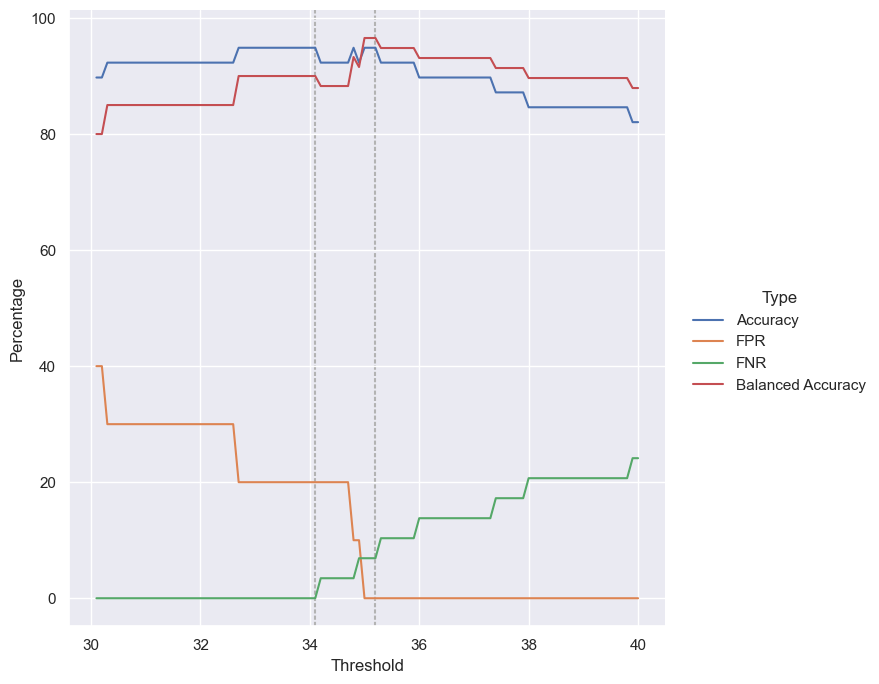

In [97]:
import seaborn as sns
import pandas

sns.set_theme()

df = pandas.DataFrame(graph, columns=["Threshold", "Type", "Percentage"])

from matplotlib import pyplot as plt
plot = sns.relplot(
    data=df,kind="line",
    x="Threshold", y="Percentage", hue="Type",height=7
)
plot.map(plt.axvline, x=best_threshold, color=".7", dashes=(2, 1), zorder=0)
plot.map(plt.axvline, x=threshold_at_highest_bal_acc, color=".7", dashes=(2, 1), zorder=0)